In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

train = pd.read_csv('train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('test.csv').drop(columns=['SAMPLE_ID'])

In [2]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

# x_train, y_train 생성
X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# x_test, y_test 생성
X_test = test

Encoding features: 100%|██████████| 6/6 [00:03<00:00,  1.54it/s]


In [3]:
mean = X_train.mean(axis=0)
X_train -= mean
std = X_train.std(axis=0)
X_train /= std

X_test -= mean
X_test /= std

In [4]:
X_train.shape[1]

30

In [5]:
from keras import models
from keras import layers

def build_model(): # 동일한 모델을 여러 번 생성할 것이므로 함수를 만들어 사용
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu',
                           input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [6]:
import numpy as np

k = 4

num_val_samples = len(X_train) // k
num_epochs = 3
all_scores = []

for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]  # 검증 데이터 준비: k번째 분할
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(  # 훈련 데이터 준비: 다른 분할 전체
        [X_train[:i * num_val_samples],
         X_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()  # 케라스 모델 구성(컴파일 포함)
    model.fit(partial_train_data, partial_train_targets,  # 모델 훈련(verbose=0이므로 훈련 과정이 출력되지 않습니다.)
              epochs=num_epochs, batch_size=100, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)  # 검증 세트로 모델 평가
    all_scores.append(val_mae)


처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [7]:
all_scores

[66.50399780273438, 65.00955963134766, 64.96509552001953, 71.6214599609375]

In [8]:
np.mean(all_scores)

67.02502822875977

In [9]:
print(history.history.keys())


NameError: ignored

In [10]:
num_epochs = 100
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]  #검증 데이터 준비: k번째 분할    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(  # 훈련 데이터 준비: 다른 분할 전체
        [X_train[:i * num_val_samples],
         X_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)

model = build_model()  # 케라스 모델 구성(컴파일 포함)
history = model.fit(partial_train_data, partial_train_targets,  # 모델 훈련(verbose=0이므로 훈련 과정이 출력되지 않습니다.)
                    validation_data=(val_data, val_targets),
                    epochs=num_epochs, batch_size=100, verbose=0)
mae_history = history.history['val_mae']
all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [11]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

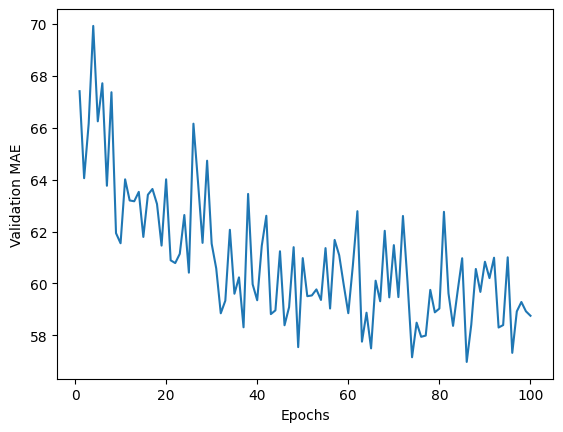

In [12]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

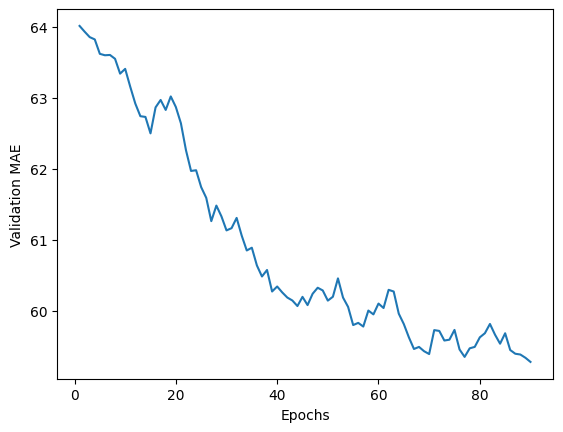

In [13]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [15]:
model = build_model()  # 새롭게 컴파일된 모델을 얻습니다.
model.fit(X_train, y_train,  # 전체 데이터로 훈련시킵니다.
          epochs=100, batch_size=100, verbose=0)
predictions = model.predict(X_test)


7656/7656 [==============================] - 12s 2ms/step


In [16]:
submit = pd.read_csv('./sample_submission.csv')
submit['CI_HOUR'] = predictions
submit.to_csv('./baseline_submit.csv', index=False)

In [ ]:
# 에포크 늘려보기